### Library design: low or high complexity?

- An important tradeoff in transposon sequencing experiments is that if there are more distinct transposon mutations in the library, then there are necessarily fewer reads per mutation. 
- Effectively, one can choose between measuring many mutations at a low sequencing depth, or fewer mutations at high sequencing depth. 
- Another consideration is that we average over individual insertion mutations within a gene to assess the effect of a gene disruption. So, we can average over many, but less precise measurements, or fewer, but more precise measurements.
- Here I explore through some quick simulations to what extent does the uncertainty in fitness measurements for disrupting a gene depend on library complexity, and what is the optimal library design (if there is)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In this quick estimation, I want to figure out for a fixed sequencing depth, should it be split between a lot of insertion sites in a gene and averaged, or should we sequence fewer sites in a gene at high depth

### Preliminary estimation

Let's consider a gene with 60 insertion sites (the typical number of sites for a gene that is 1kb long). In scenario 1, all 60 are represented in sequencing data, in scenario 2, only 24 are represented

In [2]:
n1 = 60
n2 = 24

In [61]:
coverage1 = 25
coverage2 = coverage1*n1/n2

Summary of the calculation below:
- the error in estimate for a mutation at a neutral site is defined as:
$ \Delta s_{site} = \dfrac{log\Big(\frac{n+\sqrt{n}}{n+\sqrt{n}}\Big)}{t}$
- the error for the gene is $\Delta s_{site}/\sqrt{\# sites}$

In [46]:
#quick and dirty error estimate
e1 = 1/6.64/np.sqrt(n1)*np.log((coverage1+np.sqrt(coverage1))/(coverage1-np.sqrt(coverage1)))
e2 = 1/6.64/np.sqrt(n2)*np.log((coverage2+np.sqrt(coverage2))/(coverage2-np.sqrt(coverage2)))
print(e1)
print(e2)

0.0039015776184576907
0.003893734691837076


Interesting: it doesn't seem to matter how many sites we have; the error in the fitness effect of the gene is approximately the same

### Let's repeat this but instead of error estimation, we will simulate counts for neutral mutations, and average errors in scenarios 1 and 2

Since we are assuming that the mutating the gene has no effect, any noise should purely be from Poisson distributed counts

In [62]:
sc1_t0 = np.random.poisson(coverage1, n1)
sc1_t1 = np.random.poisson(sc1_t0)
sc2_t0 = np.random.poisson(coverage2, n2)
sc2_t1 = np.random.poisson(sc2_t0)

Now let's calculate fitness in these two scenarios

In [63]:
fitness_sc1 = np.log(sc1_t1/sc1_t0*np.sum(sc1_t0)/np.sum(sc1_t1))/6.64
fitness_sc2 = np.log(sc2_t1/sc2_t0*np.sum(sc2_t0)/np.sum(sc2_t1))/6.64

Now let's look at the means and standard deviations of the fitness estimates for the same gene in the two scenarios

In [64]:
print(np.mean(fitness_sc1))
print(np.std(fitness_sc1)/np.sqrt(n1-1))

-0.002892327611400504
0.003311497110702567


In [65]:
print(np.mean(fitness_sc2))
print(np.std(fitness_sc2)/np.sqrt(n2-1))

-0.0011765221623909743
0.003508586032739844


Again, the errors in estimation are very similar

### Let's try drawing number of reads from an exponential distribution, instead of a Poisson!

The initial distribution of reads at the start of a fitness assay is never a Poisson distribution; an exponential distribution often is a better fit (though something like a lognormal or a negative binomial is probably even better). 

Here, I use exponential distributions for their convenience, and to explore how a more heavy-tailed initial read distribution impacts errors in fitness estimation.

In [66]:
n1 = 60
n2 = 24

In [67]:
sc1_t0_exp = np.random.exponential(coverage1, n1)
#sc1_t1_exp = np.random.exponential(coverage1, n1)
sc2_t0_exp = np.random.exponential(coverage2, n2)
#sc2_t1_exp = np.random.exponential(coverage2, n2)
sc1_t1_exp = np.zeros(n1)
sc2_t1_exp = np.zeros(n2)
for i in range(0, n1):
    sc1_t1_exp[i] = np.random.poisson(sc1_t0_exp[i])
for i in range(0, n2):
    sc2_t1_exp[i] = np.random.poisson(sc2_t0_exp[i])

In [68]:
mask1 = (sc1_t0_exp > 0) & (sc1_t1_exp>0)
mask2 = (sc2_t0_exp > 0) & (sc2_t1_exp>0)

In [69]:
sc1_t0_exp = sc1_t0_exp[mask1]
sc1_t1_exp = sc1_t1_exp[mask1]
sc2_t0_exp = sc2_t0_exp[mask2]
sc2_t1_exp = sc2_t1_exp[mask2]

In [70]:
fitness_sc1_exp = np.log(sc1_t1_exp/sc1_t0_exp*np.sum(sc1_t0_exp)/np.sum(sc1_t1_exp))/6.64
fitness_sc2_exp = np.log(sc2_t1_exp/sc2_t0_exp*np.sum(sc2_t0_exp)/np.sum(sc2_t1_exp))/6.64

Text(0, 0.5, 'counts')

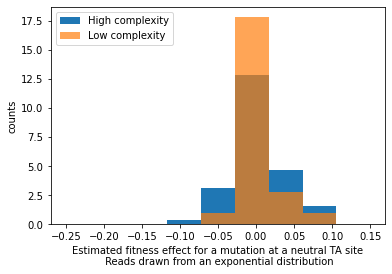

In [71]:
plt.hist(fitness_sc1_exp, bins=np.linspace(-0.25,0.15,10), label='High complexity', density=True)
plt.hist(fitness_sc2_exp, bins=np.linspace(-0.25,0.15,10), label='Low complexity', density=True, alpha=0.7)
plt.xlabel("Estimated fitness effect for a mutation at a neutral TA site\n Reads drawn from an exponential distribution")
plt.legend(loc=0)
plt.ylabel("counts")

In [73]:
print('error at low complexity:', np.std(fitness_sc2_exp)/np.sqrt(np.size(fitness_sc2_exp)-1))

error at low complexity: 0.005456650780272019


In [75]:
print('error at high complexity:', np.std(fitness_sc1_exp)/np.sqrt(np.size(fitness_sc1_exp)-1))

error at high complexity: 0.005042667886316579


As previously, there seems to be very similar errors in the low and high complexity libraries (the precise numbers can vary due to randomness in the simulation)

### Now, let's tune the initial library complexity and see how that affects the variation in fitness estimates

In [14]:
complexity = np.linspace(2*10**4, 10**6, 200)

In [15]:
#these are the proportion of unique TA sites represented in the sequencing data on average
fraction_sites = 1 - np.exp(-complexity/211995)

Text(0, 0.5, 'Fraction of Insertion Sites Expected\n to Present in Counts Data ')

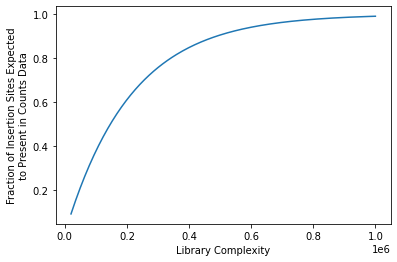

In [17]:
plt.plot(complexity, fraction_sites)
plt.xlabel('Library Complexity')
plt.ylabel('Fraction of Insertion Sites Expected\n to Present in Counts Data ')

In [18]:
#number of sites represented in a gene
n_gene = np.round(fraction_sites*60)

In [19]:
#number of reads (for an entire library)
n_reads = 5*10**6
rps = n_reads/fraction_sites/211995

In [20]:
errors = 1/6.64/np.sqrt(n_gene)*np.log((rps+np.sqrt(rps))/(rps-np.sqrt(rps)))

Text(0, 0.5, 'Error in fitness estimate \n(averaged over all sites within a gene)')

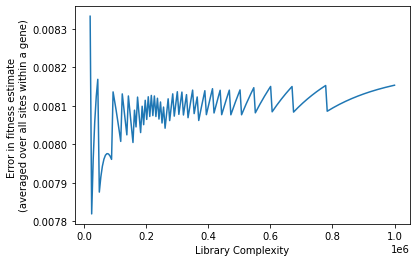

In [22]:
plt.plot(complexity, errors)
plt.xlabel('Library Complexity')
plt.ylabel('Error in fitness estimate \n(averaged over all sites within a gene)')

let's generate the same plot without the weird squiggles due to rounding off 

In [23]:
#let's stick to a linearly spacing in terms of number of sites represented per gene
n_genes1 = np.linspace(1,59,59)
#now, I'll infer a complexity of transposon library which leads to representing these many genes
complexity1 = -np.log(1-n_genes1/60)*211995

In [24]:
#reads per site
rps1 = n_reads*60/n_genes1/211995

In [25]:
errors1 = 1/6.64/np.sqrt(n_genes1)*np.log((rps1+np.sqrt(rps1))/(rps1-np.sqrt(rps1)))

Text(0, 0.5, 'error in sequencing')

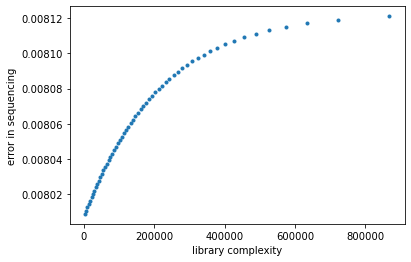

In [26]:
plt.plot(complexity1, errors1, '.')
plt.xlabel("library complexity")
plt.ylabel("error in fitness estimates")

Results: 

- while errors in fitness estimates are slightly smaller for less complex libraries, the effect is very small (0.00802 vs 0.00812), almost to the point of being indistinguishable from a practical standpoint.


### Main takeaway: it probably does not make much sense to optimize library complexity too much as it has no effect on improving fitness estimates. However, if the focus of the experiment is more on gene essentiality, then optimizing library complexity is much more reasonable, as there is more statistical power for calling essentiality if more insertion sites in the genome are represented.